# Packages

In [8]:
import time  # For timing operations
import warnings  # To manage warning messages
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from time import time  # For measuring time
import matplotlib.pyplot as plt  # For data visualization
from scipy.optimize import minimize  # For optimization tasks
from joblib import Parallel, delayed  # For parallel processing
from sklearn.linear_model import LogisticRegression, Lasso  # For logistic regression and Lasso regression
from sklearn.metrics import (  auc, roc_curve, roc_auc_score, log_loss, confusion_matrix) # For performance metrics
from sklearn.model_selection import train_test_split, KFold  # For splitting datasets and cross-validation
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.svm import SVR  # For Support Vector Regression
from sklearn.ensemble import RandomForestRegressor  # For Random Forest regression
from firthlogist import FirthLogisticRegression  # For Firth Logistic Regression
from sklearn.utils.class_weight import compute_class_weight  # For handling class imbalance
import seaborn as sns  # For advanced data visualization

# Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set a random state for reproducibility in logistic regression fitting
randomstate = 1


In [9]:
conda env export > SMAGS.yml


Note: you may need to restart the kernel to use updated packages.


# Sensitivity Maximization At Given Specificity (SMAGS)

All the graphs in the paper were plotted by setting the random state in logistic regression equal to 1. For any other random state, you might have slightly different graphs.

In [10]:
'''
Sensitivity Maximization At Given Specificity (SMAGS):

Choosing features that have the highest sensitivity for pre-specified specificity.

Input:
- X: Features as a Pandas DataFrame.
- y: Labels as a Pandas Series of classes (0 and 1).
- SP: Threshold value for specificity (default is 0.985).
- lower_bound: Optional boundaries for the coefficients (should be of dimension X.shape[1] + 1).

Output:
A Series with coefficients of the logistic regression that maximizes sensitivity,
including intercept, threshold, specificity, sensitivity, optimization method, tolerance, jacobian approach, and AIC.
'''

def SMAGS(X, y, SP=0.985, lower_bound=None, rand=randomstate):
    n_features = X.shape[1]
    log = LogisticRegression(random_state=rand).fit(X, y)  # Fit logistic regression model
    all_coefs = np.append(log.coef_[0], log.intercept_)  # Get coefficients and intercept
    X1 = X.assign(I=1)  # Add intercept term to feature set

    def sig(M):
        # Sigmoid function
        return 1 / (1 + np.exp(-M))

    def custom_loss(coefs):
        # Custom loss function to maximize sensitivity
        m = np.matmul(X1, coefs)
        z = sig(m.astype(float))
        if len(((1 - y) * z)[(1 - y) * z != 0]) != 0:
            threshold = np.quantile(((1 - y) * z)[(1 - y) * z != 0], SP)
        else:
            threshold = 0
        y_hat = 1 * (z > threshold)  # Predicted labels based on threshold
        loss1 = np.dot(y_hat, y) / sum(y)  # Sensitivity
        return -loss1  # Return negative sensitivity for minimization

    # Set bounds for coefficients
    bnds = [(lower_bound, None) for _ in range(n_features)]
    bnds.append((None, None))  # Intercept bound

    # Define optimization methods, tolerances, and jacobian approaches
    opt_methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr']
    tolerance = [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 1e-4, 1e-5, 1e-6]
    jacob_approach = ['2-point', '3-point', 'cs']

    def process_params(met, tol, jac):
        # Process parameters for optimization
        result = minimize(fun=custom_loss, x0=np.abs(all_coefs), method=met, tol=tol, bounds=bnds, jac=jac)
        a = np.matmul(X1, result.x)  # Predicted values
        b = sig(a.astype(float))
        
        if len(((1 - y) * b)[(1 - y) * b != 0]) != 0:
            c = np.quantile(((1 - y) * b)[(1 - y) * b != 0], SP)
        else:
            c = 0
        d = 1 * (b > c)  # Predicted labels based on updated threshold

        # Create a Series to hold results
        row = pd.Series(index=np.append(np.array(['B' + str(i) for i in range(1, n_features + 1)]),
                                         np.array(['B0', 'method', 'tolerance', 'jacobian', 'threshold',
                                                   'Specificity', 'Sensitivity', 'AIC'])))
        row[0:(n_features + 1)] = result.x  # Coefficients and intercept
        row['method'] = met
        row['tolerance'] = tol
        row['jacobian'] = jac
        row['threshold'] = SP
        row['Specificity'] = np.dot(1 - d, 1 - y) / sum(1 - y)  # Calculate specificity
        row['Sensitivity'] = np.dot(d, y) / sum(y)  # Calculate sensitivity
        row['AIC'] = 2 * ((n_features + 1) - log_loss(y, sig(np.matmul(X1, result.x).astype(float))))  # Calculate AIC

        return row

    # Run the optimization in parallel for different methods, tolerances, and Jacobian approaches
    results = Parallel(n_jobs=-1)(delayed(process_params)(met, tol, jac) for met in opt_methods
                                   for tol in tolerance for jac in jacob_approach)

    max_sn = pd.DataFrame(results)
    # Filter for the maximum sensitivity and then minimize AIC
    A = max_sn[max_sn.Sensitivity == max_sn.Sensitivity.max()]
    return A[A.AIC == A.AIC.min()].iloc[0]  # Return the optimal result


In [11]:
'''
Choosing features that have the highest sensitivity for pre-specified specificity.

Input:
- X: Pandas DataFrame of features.
- y: Pandas Series of classes (class column).
- SP: The value for specificity.
- lower_bound: Optional boundaries for the coefficients of the feature (should be of dimension X.shape[1] + 1).
- num_features_to_keep: The number of features to keep that maximize sensitivity at the given specificity.

Output:
- List of features (with the length of num_features_to_keep).
'''

def feature_selection(X, y, SP, lower_bound=None, num_features_to_keep=2):
    Features = list(X.columns)  # List of all feature names
    One_Top = []  # List to hold selected features
    
    def sensitivity_score(feature):
        # Calculate sensitivity for a given feature
        if len(One_Top) == 0:
            return SMAGS(X=X.loc[:, [feature]], y=y, SP=SP, lower_bound=lower_bound)['Sensitivity']
        else:
            return SMAGS(X=X.loc[:, np.append(feature, One_Top)], y=y, SP=SP, lower_bound=lower_bound)['Sensitivity']

    while len(One_Top) < num_features_to_keep:
        # Calculate sensitivity scores for all features in parallel
        results = Parallel(n_jobs=-2)(delayed(sensitivity_score)(feature) for feature in Features)
        best_feature = Features[np.argmax(results)]  # Get the feature with the highest sensitivity

        Features.remove(best_feature)  # Remove the best feature from consideration
        One_Top.append(best_feature)  # Add the best feature to the selected list

    return One_Top  # Return the list of selected features


# Synthetic Data 1

We are generating a dataset with a minimum of two variables. One variable exhibits very high sensitivity at 98.5% specificity, while the other variable demonstrates very low sensitivity at the same threshold.

In [5]:
# Coefficients for feature scaling
Coef0 = 1.0
Coef1 = 4.5
Coef2 = 0.05
Coef3 = 0.15
Coef4 = 50

# Number of samples per class
m = 500
np.random_state = randomstate  # Set random state for reproducibility

# Generate Feature 1 (F1) - Length 2000 values
# F1 consists of a mix of values influenced by Coef1 (high variability) and Coef0 (low variability)
# Distribution: Uniform (scaled by coefficients)
F1 = np.concatenate([
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef1,  # Higher values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0,  # Lower values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0,  # Lower values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0   # Lower values
])

# Generate Feature 2 (F2) - Length 2000 values
# F2 has mostly low values influenced by Coef0 and some variation influenced by Coef2
# Distribution: Uniform (with skew towards lower values)
F2 = np.concatenate([
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0,  # Lower values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0,  # Lower values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0,  # Lower values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef2   # Very low values
])

# Generate Feature 3 (F3) - Length 2000 values
# F3 is influenced by Coef1 (high variability) and Coef3 (medium variability)
# Distribution: Uniform (with higher range)
F3 = np.concatenate([
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef1,  # Higher values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0,  # Lower values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef0,  # Lower values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef3   # Medium values
])

# Generate Feature 4 (F4) - Length 2000 values
# F4 consists of high values influenced by Coef4 and some lower values influenced by Coef2
# Distribution: Uniform (with a peak at high values)
F4 = np.concatenate([
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef4,  # High values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef4,  # High values
    0.001 * np.random.choice(range(1001), m, replace=True) * Coef4,  # High values
    0.001 * np.random.choice(range(1001), m, replace=True) * (Coef2 / 10)  # Very low values
])

# Create a DataFrame
# The first 1000 values are cases (1), and the next 1000 values are controls (0)
DF = pd.DataFrame({
    "is_case": np.concatenate([np.repeat(1, m), np.repeat(0, m)]),  # Class labels
    "X1": F1,  # Feature 1
    "X2": F2,  # Feature 2
    "X3": F3,  # Feature 3
    "X4": F4   # Feature 4
})


# Synthetic Data 2

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

# Define coefficients
Coef0 = 1.0
Coef1 = 4.5
Coef2 = 0.05
Coef3 = 0.15
Coef4 = 50

# Number of samples per class
m_case = 200    # Number of cases (10%)
m_control = 1800  # Number of controls (90%)

# Generate Feature 1 (F1) - Using exponential distribution
# F1 has high values for cases and lower values for controls
F1 = np.concatenate([
    np.random.exponential(1, m_case) * Coef1,  # Cases
    np.random.exponential(1, m_control) * Coef0  # Controls
])

# Generate Feature 2 (F2) - Using gamma distribution
# F2 has low values influenced by the gamma distribution
F2 = np.concatenate([
    np.random.gamma(2, 1, m_case) * Coef0,  # Cases
    np.random.gamma(2, 1, m_control) * Coef0  # Controls
])

# Generate Feature 3 (F3) - Using log-normal distribution
# F3 has a skewed distribution with higher variability for cases
F3 = np.concatenate([
    np.random.lognormal(0, 1, m_case) * Coef1,  # Cases
    np.random.lognormal(0, 1, m_control) * Coef0  # Controls
])

# Generate Feature 4 (F4) - Using a mix of exponential distributions
# F4 consists of high values influenced by the exponential distribution
F4 = np.concatenate([
    np.random.exponential(1, m_case) * Coef4,  # Cases
    np.random.exponential(1, m_control) * Coef4  # Controls
])

# Creating the DataFrame
DF_new = pd.DataFrame({
    "is_case": np.concatenate([np.repeat(1, m_case), np.repeat(0, m_control)]),  # Class labels
    "X1": F1,  # Feature 1
    "X2": F2,  # Feature 2
    "X3": F3,  # Feature 3
    "X4": F4   # Feature 4
})

# Display the first few rows of the new DataFrame
print(DF_new.head())

# Check the class distribution
print(DF_new['is_case'].value_counts())


is_case
0    1800
1     200
Name: count, dtype: int64


# Figure 1

In [8]:
# Split the data into training and testing sets
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    Xs[['X1', 'X2']],  # Select features 'X1' and 'X2' from the DataFrame
    ys,                # Target labels (is_case) to be predicted
    random_state=randomstate,  # Set random seed for reproducibility
    test_size=0.2,    # Use 20% of the data for testing
    shuffle=True       # Shuffle the data before splitting to avoid bias
)

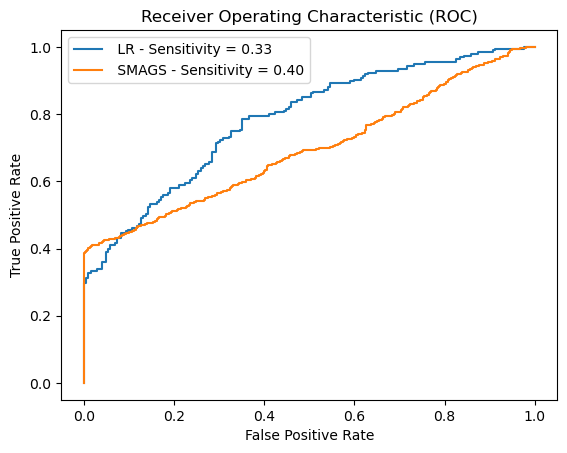

In [9]:
# Fit a logistic regression model on the training data
log = LogisticRegression(random_state=randomstate).fit(Xs_train, ys_train)

# Predict probabilities on the test set
ys_probs1 = log.predict_proba(Xs_test)

# Calculate the ROC curve for the logistic regression model
fpr_train, tpr_train, _ = roc_curve(ys_test, ys_probs1[:, 1])

# Plot the ROC curve for the logistic regression model
plt.plot(fpr_train, tpr_train, label='LR - Sensitivity = %0.2f' % tpr_train[np.argmin(1 - fpr_train > 0.985)])

# Perform SMAGS feature selection and get the coefficients
A = SMAGS(Xs_train, ys_train, 0.985)

# Calculate the ROC curve for the SMAGS model
fpr_smag, tpr_smag, _ = roc_curve(ys_train, np.matmul(np.array(Xs_train.assign(I=1)), np.array(A[0:3])))

# Plot the ROC curve for the SMAGS model
plt.plot(fpr_smag, tpr_smag, label='SMAGS - Sensitivity = %0.2f' % tpr_smag[np.argmin(1 - fpr_smag > 0.985)])

# Add legend and labels to the plot
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Save the figure as a PNG file
plt.savefig('Figure 2.png')

# Display the plot
plt.show()

# Figure 2

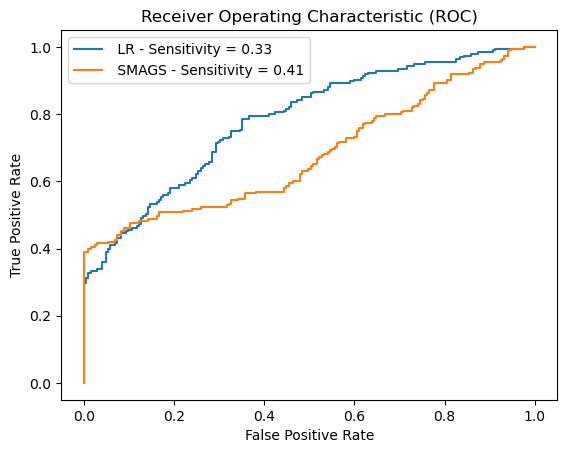

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Predict probabilities on the test set using the logistic regression model
ys_probs2 = log.predict_proba(Xs_test)

# Calculate the ROC curve for the logistic regression model on the test set
fpr_test, tpr_test, _ = roc_curve(ys_test, ys_probs2[:, 1])

# Plot the ROC curve for the logistic regression model
plt.plot(fpr_test, tpr_test, label='LR - Sensitivity = %0.2f' % tpr_test[np.argmin(1 - fpr_test > 0.985)])

# Calculate the ROC curve for the SMAGS model on the test set
fpr_smag2, tpr_smag2, _ = roc_curve(ys_test, np.matmul(np.array(Xs_test.assign(I=1)), np.array(A[0:3])))

# Plot the ROC curve for the SMAGS model
plt.plot(fpr_smag2, tpr_smag2, label='SMAGS - Sensitivity = %0.2f' % tpr_smag2[np.argmin(1 - fpr_smag2 > 0.985)])

# Add legend and labels to the plot
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Save the figure as a PNG file
plt.savefig('Figure 3.png')

# Display the plot
plt.show()


# SM Figure 1

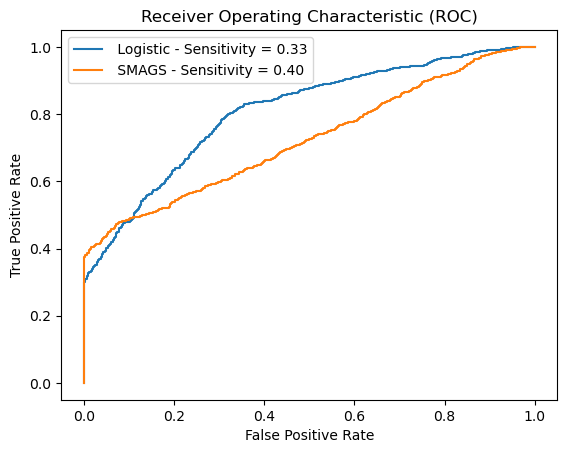

In [15]:
# Fit a logistic regression model on the entire dataset
log = LogisticRegression(random_state=randomstate).fit(Xs[['X1', 'X2']], ys)

# Predict probabilities for the dataset
ys_probs = log.predict_proba(Xs[['X1', 'X2']])

# Calculate the ROC curve for the logistic regression model
fpr_log, tpr_log, _ = roc_curve(ys, ys_probs[:, 1])

# Plot the ROC curve for the logistic regression model
plt.plot(fpr_log, tpr_log, label='Logistic - Sensitivity = %0.2f' % tpr_log[np.argmin(1 - fpr_log > 0.985)])

# Perform SMAGS feature selection and get the coefficients
A = SMAGS(Xs[['X1', 'X2']], ys, 0.985)

# Calculate the ROC curve for the SMAGS model
fprs_all_smag, tprs_all_smag, _ = roc_curve(ys, np.matmul(np.array(Xs[['X1', 'X2']].assign(I=1)), np.array(A[0:3])))

# Calculate the AUC for the SMAGS model
roc_auc_all_smag = auc(fprs_all_smag, tprs_all_smag)

# Plot the ROC curve for the SMAGS model
plt.plot(fprs_all_smag, tprs_all_smag, label='SMAGS - Sensitivity = %0.2f' % tprs_all_smag[np.argmin(1 - fprs_all_smag > 0.985)])

# Uncomment the lines below if you want to plot additional ROC curves
# plt.plot(fpr1, tpr1, label='F1 - Sensitivity = {:.2f}'.format(tpr1[np.argmin(1 - fpr1 > 0.985)]))
# plt.plot(fpr2, tpr2, label='F2 - Sensitivity = {:.2f}'.format(tpr2[np.argmin(1 - fpr2 > 0.985)]))

# Add legend and labels to the plot
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')

# Save the figure as a PNG file
plt.savefig('Figure 4.png')

# Display the plot
plt.show()

 # SM Figure 2

In [10]:
# Select features and target labels from the new DataFrame
Xs_new = DF_new[['X1', 'X2', 'X3', 'X4']]  # Features: X1, X2, X3, X4
ys_new = DF_new['is_case']                  # Target label: is_case (1 for cases, 0 for controls)

# Split the new data into training and testing sets
Xs_train_new, Xs_test_new, ys_train_new, ys_test_new = train_test_split(
    Xs_new,                # Features to be split
    ys_new,               # Target labels to be split
    random_state=randomstate,  # Set random seed for reproducibility
    test_size=0.2,        # Use 20% of the data for testing
    shuffle=True           # Shuffle the data before splitting to avoid bias
)

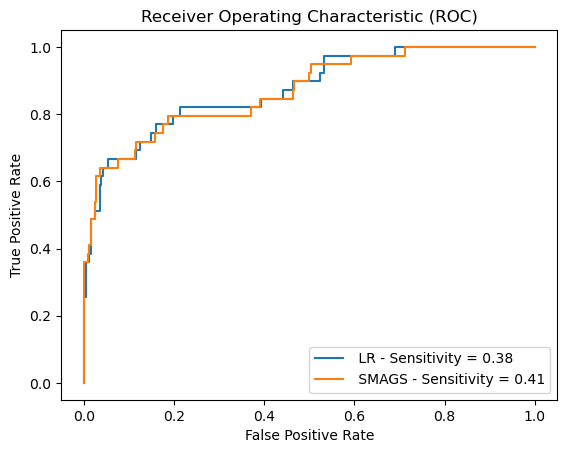

In [11]:
# Fit a logistic regression model on the training set
log_new = LogisticRegression(random_state=randomstate).fit(Xs_train_new, ys_train_new)

# Predict probabilities on the test set using the logistic regression model
ys_probs1_new = log_new.predict_proba(Xs_test_new)

# Calculate the ROC curve for the logistic regression model on the test set
fpr_train_new, tpr_train_new, _ = roc_curve(ys_test_new, ys_probs1_new[:, 1])

# Plot the ROC curve for the logistic regression model
plt.plot(fpr_train_new, tpr_train_new, label='LR - Sensitivity = %0.2f' % tpr_train_new[np.argmin(1 - fpr_train_new > 0.985)])

# Perform SMAGS feature selection and get the coefficients
A_new = SMAGS(Xs_train_new, ys_train_new, 0.985)

# Calculate the ROC curve for the SMAGS model using the test set
fpr_smag_new, tpr_smag_new, _ = roc_curve(ys_test_new, np.matmul(np.array(Xs_test_new.assign(I=1)), np.array(A_new[0:5])))

# Plot the ROC curve for the SMAGS model
plt.plot(fpr_smag_new, tpr_smag_new, label='SMAGS - Sensitivity = %0.2f' % tpr_smag_new[np.argmin(1 - fpr_smag_new > 0.985)])

# Add legend and labels to the plot
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Save the figure as a PNG file
plt.savefig('SMF1.png')

# Display the plot
plt.show()

# SM F3

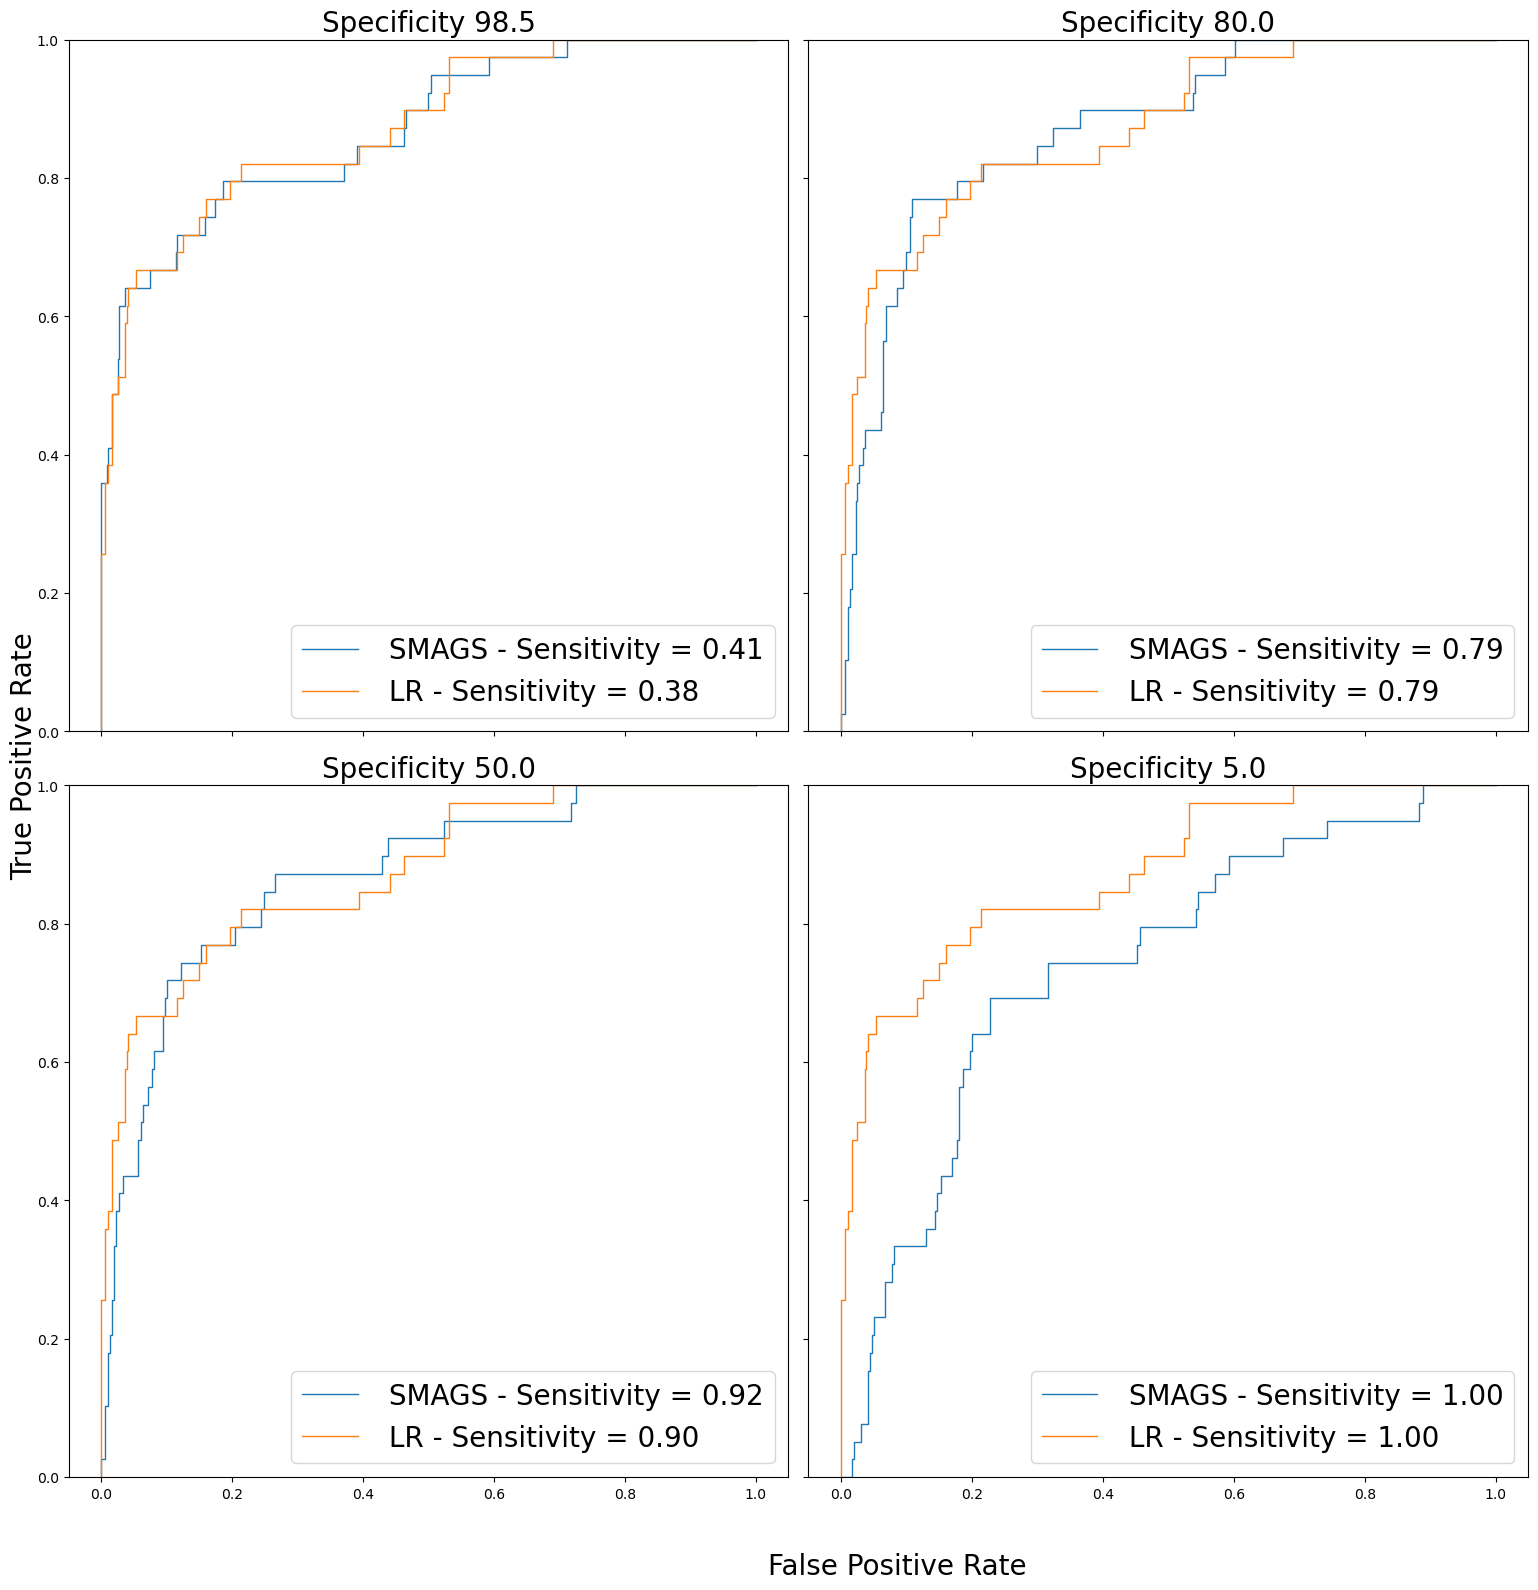

In [12]:
# Set plot parameters
linewidth = 1
fonts = 20
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rc('axes', labelsize=10)

# Create a 2x2 subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), constrained_layout=True, sharex=True, sharey=True)

# Set y-ticks for all subplots
plt.setp(axes, yticks=np.linspace(0, 1, 6, endpoint=True))

# Define specificities to analyze
specificities = [0.985, 0.80, 0.5, 0.05]

# Loop over each specificity to generate ROC curves
for i, SP in enumerate(specificities):
    # Get SMAGS results for the current specificity
    A_new = SMAGS(Xs_train_new, ys_train_new, SP)
    
    # Calculate ROC curve for SMAGS
    fpr_smag_new, tpr_smag_new, _ = roc_curve(ys_test_new, 
        np.matmul(np.array((Xs_test_new).assign(I=1)), np.array(A_new[0:5])))

    # Plot SMAGS ROC curve
    axes[i // 2, i % 2].plot(fpr_smag_new, tpr_smag_new, 
        label='SMAGS - Sensitivity = %0.2f' % tpr_smag_new[np.argmin(1 - fpr_smag_new > SP)], linewidth=linewidth)

    # Plot logistic regression ROC curve
    axes[i // 2, i % 2].plot(fpr_train_new, tpr_train_new, 
        label='LR - Sensitivity = %0.2f' % tpr_train_new[np.argmin(1 - fpr_train_new > SP)], linewidth=linewidth)

    # Set legend and title for the subplot
    axes[i // 2, i % 2].legend(prop={'size': fonts})
    axes[i // 2, i % 2].set_title("Specificity " + str(SP * 100), fontsize=fonts, fontweight="normal")

# Set limits and labels for the overall figure
plt.ylim([0, 1])
fig.text(0.49, -0.05, 'False Positive Rate', ha='left', va='bottom', fontsize=fonts)  # x-label
fig.text(-0.015, 0.5, 'True Positive Rate', ha='left', va='center', rotation='vertical', fontsize=fonts)  # y-label

# Save the figure and display it
plt.savefig('Figure 2_3.png')
plt.show()


# Table 1

In [16]:
# Split the dataset into training and test sets
Xs_train_four, Xs_test_four, ys_train_four, ys_test_four = train_test_split(
    Xs,  # Features
    ys,  # Labels
    random_state=randomstate,  # Set random seed for reproducibility
    test_size=0.2,  # Use 20% of the data for testing
    shuffle=True  # Shuffle the data before splitting
)


In [17]:
# Fit a logistic regression model on the training data
log_four = LogisticRegression(random_state=randomstate).fit(Xs_train_four, ys_train_four)

# Predict probabilities for the test set
ys_probs_four = log_four.predict_proba(Xs_test_four)

# Calculate the false positive rate (FPR) and true positive rate (TPR) for the ROC curve
fpr_log_four, tpr_log_four, _ = roc_curve(ys_test_four, ys_probs_four[:, 1])


In [18]:
# Define a list of specificity thresholds to evaluate
all_spec = [0.01, 0.05, 0.1, 0.5, 0.8, 0.9, 0.95, 0.985]

# Start timing for performance measurement
ti = time()

# Create a DataFrame to hold specificity and sensitivities for both models
table1 = pd.DataFrame(index=np.arange(0, len(all_spec), 1),
                      columns=['Specificity', 'Logistic Sensitivity', 'SMAGS Sensitivity'])

# Loop over each specificity threshold
for i, j in enumerate(all_spec):
    # Store the specificity value (in percentage)
    table1.iloc[i, 0] = j * 100
    
    # Calculate the sensitivity for the logistic model at the given specificity
    table1.iloc[i, 1] = np.round((tpr_log_four[np.argmin(1 - fpr_log_four > j)]) * 100, 2)
    
    # Run SMAGS to get the coefficients at the current specificity
    A_four = SMAGS(Xs_train_four, ys_train_four, j)
    
    # Compute ROC curve for the SMAGS model on the test set
    fprs_smag_four, tprs_smag_four, _ = roc_curve(ys_test_four,
                                                   np.matmul(np.array((Xs_test_four).assign(I=1)),
                                                             np.array(A_four[0:5])))
    
    # Store the SMAGS sensitivity at the given specificity
    table1.iloc[i, 2] = np.round((tprs_smag_four[np.argmin(1 - fprs_smag_four > j)]) * 100, 2)

# Print the last index and elapsed time
print(i, time() - ti)


7 28.1863272190094


# CancerSeek Data

In this section we are using the dataset provided by 
"Cohen, J. D., Li, L., Wang, Y., Thoburn, C., Afsari, B., Danilova, L., ... & Papadopoulos, N. (2018). Detection and localization of surgically resectable cancers with a multi-analyte blood test. Science, 359(6378), 926-930."

In [12]:
# Reading CancerSeek Data from the specified Excel file
S2 = pd.read_excel('CRC_Analysis.xlsx', sheet_name='Sheet2')
S2.columns = S2.loc[1]  # Set the second row as column headers
S3 = pd.read_excel('CRC_Analysis.xlsx', sheet_name='Sheet3')  # Read the second sheet

# Selecting features that are marked as 'Increased' from sheet 3
# and have a corresponding value greater than 0.6 in the second column
Main_Features = np.array(S3.loc[(S3.iloc[:, 7] == 'Increased') & (S3.iloc[1:, 1] > 0.6)]['Unnamed: 0'])

# Converting character values to numeric for specific entries
S2.loc[29, 'CEA (pg/ml)'] = 336427.986
S2.loc[349, 'Prolactin (pg/ml)'] = 608432.382

# Preparing the final DataFrame with the tumor type and selected main features
df = S2.loc[2:, np.append('Tumor type', Main_Features)]  # Selecting relevant rows and columns
df = df.dropna()  # Dropping rows with any NaN values


In [13]:
# Preparing Features and Labels
X = df.iloc[:, 1:]  # Selecting all columns except the first one for features
# X.iloc[27, 1] = 336427.986  # Uncomment to set specific values if needed
# X.iloc[347, 13] = 608432.382  # Uncomment to set specific values if needed

y1 = df.iloc[:, 0]  # Selecting the first column as labels
X = X.astype(float)  # Converting features to float type

# Creating a binary target variable: 1 for 'Colorectum', 0 otherwise
y = pd.Series(np.where(y1 == 'Colorectum', 1, 0), index=y1.index)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=randomstate, test_size=0.2, shuffle=True)


# Figure 3

C:\Users\sghasemi\Anaconda3\envs\SMAGS\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sghasemi\Anaconda3\envs\SMAGS\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

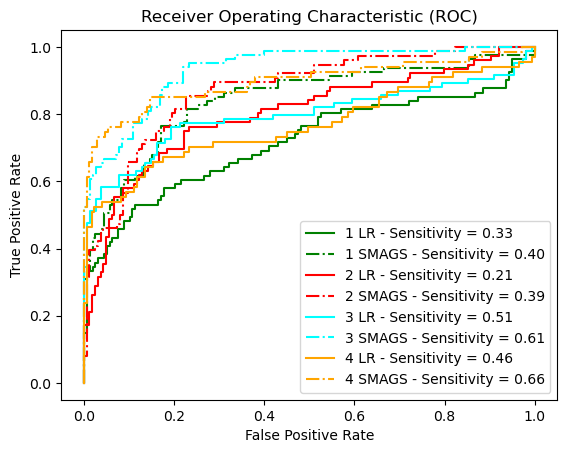

In [15]:
# Setting up parameters for cross-validation
i = 0  # Counter for folds
SP = 0.985  # Target specificity
n_fold = 4  # Number of folds for cross-validation

# Lists to store coefficients and parameters
B_train = []
D_train = []
S_train = []

# Colors for plotting different folds
colors = ['blue', 'green', 'red', 'cyan', 'orange', 'magenta']

# KFold cross-validation setup
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=randomstate)

# Cross-validation loop
for train, test in kfold.split(X_train):
    i += 1  # Increment fold counter

    # Fit logistic regression model on training data
    log = LogisticRegression(random_state=randomstate).fit(X_train.loc[X_train.index[train]], y_train.loc[y_train.index[train]])
    B_train.append(np.append(log.coef_[0], log.intercept_))  # Store coefficients

    # Predict probabilities on test fold
    y_probs1 = log.predict_proba(X_train.loc[X_train.index[test]])
    fpr1, tpr1, _ = roc_curve(y_train.loc[y_train.index[test]], y_probs1[:, 1])  # Compute ROC curve
    roc_auc1 = auc(fpr1, tpr1)  # Compute AUC (commented out in plot)

    # Apply SMAGS method on training fold
    A = SMAGS(X_train.loc[X_train.index[train]], y_train.loc[y_train.index[train]], SP)
    D_train.append(np.array(A[:X.shape[1] + 1]))  # Store SMAGS parameters

    # Compute ROC curve for SMAGS
    fpr_smags, tpr_smags, _ = roc_curve(y_train.loc[y_train.index[test]],
        np.matmul(np.array((X_train.loc[X_train.index[test]]).assign(I=1)), np.array(A[:X.shape[1] + 1])))

    roc_auc_smags = auc(fpr_smags, tpr_smags)  # Compute AUC (commented out in plot)

    # Plot ROC curve for Logistic Regression
    plt.plot(fpr1, tpr1, '-', color=colors[i], label=str(i) + ' LR - Sensitivity = %0.2f' % tpr1[np.argmin(1 - fpr1 > SP)])

    # Plot ROC curve for SMAGS
    plt.plot(fpr_smags, tpr_smags, '-.', color=colors[i], label=str(i) + ' SMAGS - Sensitivity = %0.2f' % tpr_smags[np.argmin(1 - fpr_smags > SP)])

# Final plot settings
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('F 3.png')  # Save the figure
plt.show()  # Display the plot


# SVM

In [16]:

# Initialize the Support Vector Regression model
svc = SVR()

# Fit the model on the training data
svc.fit(X_train, y_train)

# Predicting for the test set
y_pred_svm = svc.predict(X_test)

# ROC curve calculation
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)  # Compute false positive rate and true positive rate
roc_auc_svm = auc(fpr_svm, tpr_svm)  # Calculate the area under the curve



# Random Forest

In [17]:

# Initialize the Random Forest Regressor with a maximum depth of 1
rf = RandomForestRegressor(max_depth=1)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predicting for the test set
y_pred_rf = rf.predict(X_test)

# ROC curve calculation
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)  # Compute false positive rate and true positive rate
roc_auc_rf = auc(fpr_rf, tpr_rf)  # Calculate the area under the curve



# Weighted Logistic Regression 

In [18]:

# Calculate class weights to handle imbalanced classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Initialize Logistic Regression with class weights
wlr = LogisticRegression(class_weight=class_weight_dict, solver='liblinear')

# Fit the model on the training data
wlr.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_wlr = wlr.predict_proba(X_test)

# Calculate ROC curve
fpr_wlr, tpr_wlr, _ = roc_curve(np.array(y_test), y_pred_wlr[:, 1])
roc_auc_wlr = auc(fpr_wlr, tpr_wlr)



# Figure 4

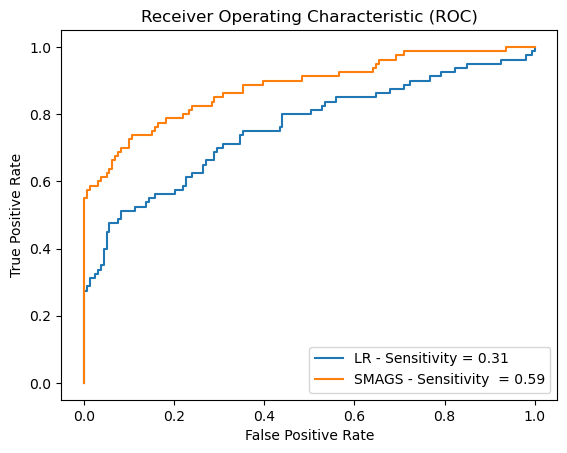

In [20]:

# Calculate average coefficients from the cross-validation results
Av_B_test = np.array(B_train).mean(axis=0)
Av_D_test = np.array(D_train).mean(axis=0)

# ROC for Logistic Regression using average coefficients
fpr_avg, tpr_avg, _ = roc_curve(y_test, np.matmul(np.array(X_test.assign(I=1)), Av_B_test))
roc_auc_avg = auc(fpr_avg, tpr_avg)

# ROC for SMAGS using average coefficients
fpr_avg_smag, tpr_avg_smag, _ = roc_curve(y_test, np.matmul(np.array(X_test.assign(I=1)), Av_D_test))
roc_auc_avg_smag = auc(fpr_avg_smag, tpr_avg_smag)

# Plotting ROC curves
plt.plot(fpr_avg, tpr_avg, label='LR - Sensitivity = %0.2f' % tpr_avg[np.argmin((1 - fpr_avg) > SP)])
plt.plot(fpr_avg_smag, tpr_avg_smag, label='SMAGS - Sensitivity = %0.2f' % tpr_avg_smag[np.argmin((1 - fpr_avg_smag) > SP)])

# Final plot settings
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('F 4.png')
plt.show()


# SM F4

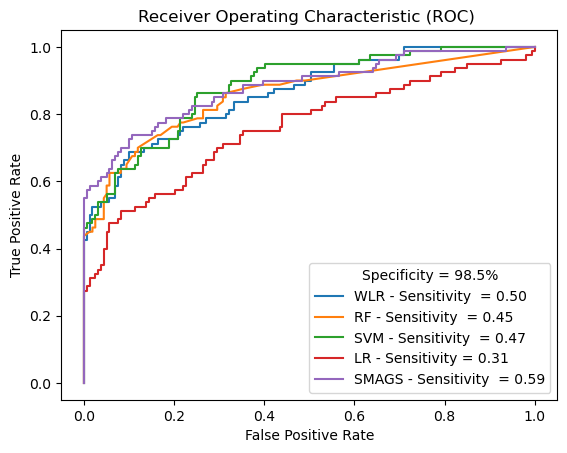

In [21]:
# Calculate average coefficients from cross-validation results
Av_B_test = np.array(B_train).mean(axis=0)
Av_D_test = np.array(D_train).mean(axis=0)

# ROC for Logistic Regression using average coefficients
fpr_avg, tpr_avg, _ = roc_curve(y_test, np.matmul(np.array(X_test.assign(I=1)), Av_B_test))
roc_auc_avg = auc(fpr_avg, tpr_avg)

# ROC for SMAGS using average coefficients
fpr_avg_smag, tpr_avg_smag, _ = roc_curve(y_test, np.matmul(np.array(X_test.assign(I=1)), Av_D_test))
roc_auc_avg_smag = auc(fpr_avg_smag, tpr_avg_smag)

# Plotting ROC curves for all models
plt.plot(fpr_wlr, tpr_wlr, label='WLR - Sensitivity = %0.2f' % tpr_wlr[np.argmin((1 - fpr_wlr) > SP)])
plt.plot(fpr_rf, tpr_rf, label='RF - Sensitivity = %0.2f' % tpr_rf[np.argmin((1 - fpr_rf) > SP)])
plt.plot(fpr_svm, tpr_svm, label='SVM - Sensitivity = %0.2f' % tpr_svm[np.argmin((1 - fpr_svm) > SP)])
plt.plot(fpr_avg, tpr_avg, label='LR - Sensitivity = %0.2f' % tpr_avg[np.argmin((1 - fpr_avg) > SP)])
plt.plot(fpr_avg_smag, tpr_avg_smag, label='SMAGS - Sensitivity = %0.2f' % tpr_avg_smag[np.argmin((1 - fpr_avg_smag) > SP)])

# Final plot settings
plt.legend(title='Specificity = 98.5%')
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('SM F4.png')
plt.show()


#  SM F5

C:\Users\sghasemi\Anaconda3\envs\SMAGS\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sghasemi\Anaconda3\envs\SMAGS\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

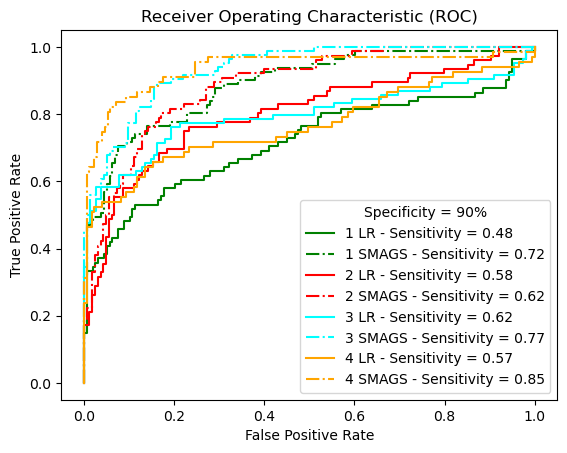

In [23]:
# Initialization
i = 0
SP9 = 0.9  # Specificity level
n_fold = 4
B_train9 = []
D_train9 = []
colors = ['blue', 'green', 'red', 'cyan', 'orange', 'magenta']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=randomstate, test_size=0.2, shuffle=True)

# K-Fold cross-validation
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=randomstate)
for train_idx, test_idx in kfold.split(X_train):
    i += 1
    
    # Train Logistic Regression model
    log = LogisticRegression(random_state=randomstate).fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    B_train9.append(np.append(log.coef_[0], log.intercept_))
    
    # Predictions and ROC for Logistic Regression
    y_probs9 = log.predict_proba(X_train.iloc[test_idx])
    fpr9, tpr9, _ = roc_curve(y_train.iloc[test_idx], y_probs9[:, 1])
    
    # SMAGS implementation
    A9 = SMAGS(X_train.iloc[train_idx], y_train.iloc[train_idx], SP9)
    D_train9.append(np.array(A9[:X.shape[1] + 1]))
    
    # Predictions and ROC for SMAGS
    fpr_smags9, tpr_smags9, _ = roc_curve(y_train.iloc[test_idx],
        np.matmul(np.array((X_train.iloc[test_idx]).assign(I=1)), np.array(A9[:X.shape[1] + 1])))
    
    # Plotting ROC curves
    plt.plot(fpr9, tpr9, '-', color=colors[i - 1], label=str(i) + ' LR - Sensitivity = %0.2f' % tpr9[np.argmin(1 - fpr9 > SP9)])
    plt.plot(fpr_smags9, tpr_smags9, '-.', color=colors[i - 1], label=str(i) + ' SMAGS - Sensitivity = %0.2f' % tpr_smags9[np.argmin(1 - fpr_smags9 > SP9)])

# Final plot settings
plt.legend(title='Specificity = 90%')
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('SM F5.png')
plt.show()


# SM F6

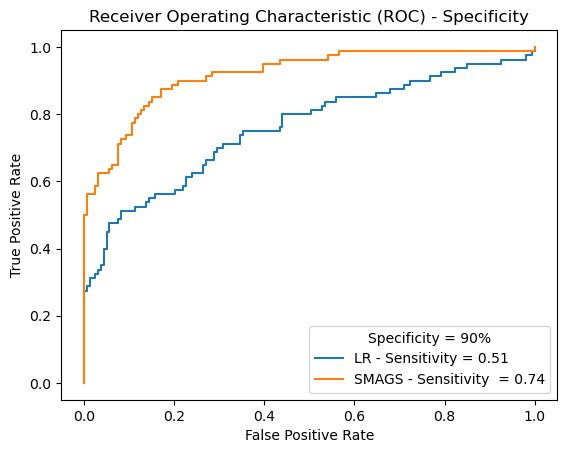

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate average coefficients for Logistic Regression and SMAGS
Av_B_test9 = np.array(B_train9).mean(axis=0)
Av_D_test9 = np.array(D_train9).mean(axis=0)

# Compute ROC curve for average Logistic Regression
fpr_avg9, tpr_avg9, _ = roc_curve(y_test, np.matmul(np.array((X_test).assign(I=1)), np.array(Av_B_test9)))

# Compute ROC curve for average SMAGS
fpr_avg_smag9, tpr_avg_smag9, _ = roc_curve(y_test, np.matmul(np.array((X_test).assign(I=1)), np.array(Av_D_test9)))

# Plotting ROC curves
# plt.plot(fpr_wlr, tpr_wlr, label='WLR - Sensitivity = %0.2f' % tpr_wlr[np.argmin((1 - fpr_wlr) > SP9)])  # Uncomment if needed
# plt.plot(fpr_rf, tpr_rf, label='RF - Sensitivity = %0.2f' % tpr_rf[np.argmin((1 - fpr_rf) > SP9)])  # Uncomment if needed
# plt.plot(fpr_svm, tpr_svm, label='SVM - Sensitivity = %0.2f' % tpr_svm[np.argmin((1 - fpr_svm) > SP9)])  # Uncomment if needed
plt.plot(fpr_avg9, tpr_avg9, label='LR - Sensitivity = %0.2f' % tpr_avg9[np.argmin((1 - fpr_avg9) > SP9)])
plt.plot(fpr_avg_smag9, tpr_avg_smag9, label='SMAGS - Sensitivity = %0.2f' % tpr_avg_smag9[np.argmin((1 - fpr_avg_smag9) > SP9)])

# Final plot settings
plt.legend(title='Specificity = 90%')
plt.title("Receiver Operating Characteristic (ROC) - Specificity")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('SM F6.png')
plt.show()


# Feature Selection => SP=0.985

In [55]:
n_selecting_features = 8  # Number of features to keep
ti = time()  # Start timer

# Perform feature selection
selected_features = feature_selection(X, y, SP=0.985, num_features_to_keep=n_selecting_features)

# Print time taken for feature selection
print('Time taken for feature selection:', np.round(time() - ti, 2), 'seconds')


 time  2227.0


In [57]:
# Fit Logistic Regression model using selected features
log_res = LogisticRegression(random_state=randomstate).fit(X_train.loc[:, selected_features], y_train)

# Extract coefficients and intercept
log_coef_res = np.append(log_res.coef_[0], log_res.intercept_)

# Predict probabilities for the test set using selected features
y_pred_res = np.array(log_res.predict_proba(X_test.loc[:, selected_features]))


C:\Users\sghasemi\Anaconda3\envs\SMAGS\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Figure 5

C:\Users\sghasemi\Anaconda3\envs\SMAGS\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


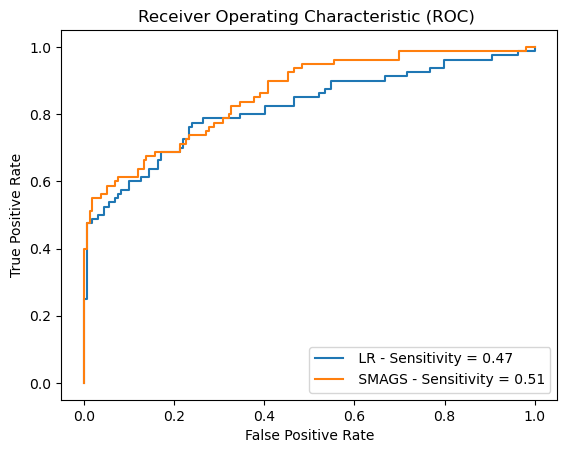

In [58]:
# Calculate ROC curve and AUC for Logistic Regression with selected features
fpr_log_res, tpr_log_res, _ = roc_curve(y_test, y_pred_res[:, 1])
roc_auc_log_res = auc(fpr_log_res, tpr_log_res)
plt.plot(fpr_log_res, tpr_log_res, label='LR - Sensitivity = %0.2f' % tpr_log_res[np.argmin((1 - fpr_log_res) > SP)])

# Calculate ROC curve and AUC for SMAGS with selected features
smag_coef_res = SMAGS(X=X_train.loc[:, selected_features], y=y_train, SP=SP)[0:(n_selecting_features + 1)]
fpr_smag_res, tpr_smag_res, _ = roc_curve(y_test, np.matmul(np.array((X_test.loc[:, selected_features]).assign(I=1)), np.array(smag_coef_res)))
roc_auc_smag_res = auc(fpr_smag_res, tpr_smag_res)
plt.plot(fpr_smag_res, tpr_smag_res, label='SMAGS - Sensitivity = %0.2f' % tpr_smag_res[np.argmin((1 - fpr_smag_res) > SP)])

# Plot customization
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('F 5.png')
plt.show()


# LASSO

In [59]:
# Initialize MinMaxScaler
scaler = StandardScaler()

# Scale the features (both train and test)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [60]:
# Initialize and fit Lasso regression
lasso = Lasso(alpha=0.045, random_state=randomstate) 
lasso.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lasso = lasso.predict(X_test_scaled)

# Extract coefficients and features
lasso_coefs = np.append(lasso.coef_, lasso.intercept_)
lasso_features = X.columns[lasso.coef_ != 0]
lasso_col_index = [i for i, j in enumerate(X.columns) if j in lasso_features]

# Number of selected features
num_selected_features = len(lasso_features)
print(f"Number of selected features: {num_selected_features}")


8

 # Figure 6

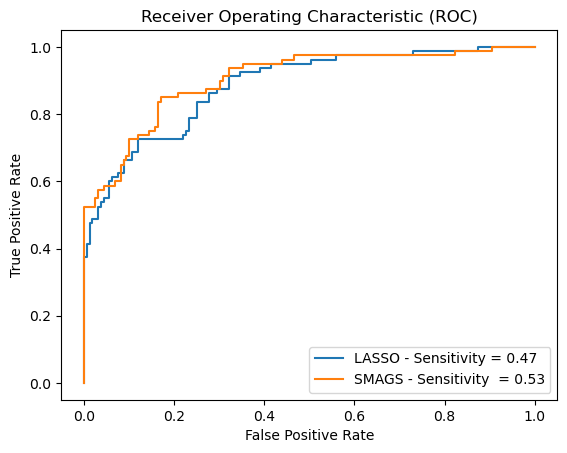

In [62]:

# Sensitivity and Specificity for LASSO
fpr_las, tpr_las, _ = roc_curve(y_test, y_pred_lasso)
roc_auc_las = auc(fpr_las, tpr_las)
plt.plot(fpr_las, tpr_las, label='LASSO - Sensitivity = %0.2f' % tpr_las[np.argmin((1 - fpr_las) > 0.985)]

# Sensitivity and Specificity for SMAGS
smag_vs_lass_coef = SMAGS(X=(X_train_scaled.iloc[:, lasso_col_index]), y=y_train, SP=0.985)[:(len(lasso_features) + 1)]
fpr_smag_vs_lass, tpr_smag_vs_lass, _ = roc_curve(y_test, np.matmul(np.array((X_test_scaled.iloc[:, lasso_col_index]).assign(I=1)), np.array(smag_vs_lass_coef)))
roc_auc_smag_vs_lass = auc(fpr_smag_vs_lass, tpr_smag_vs_lass)
plt.plot(fpr_smag_vs_lass, tpr_smag_vs_lass, label='SMAGS - Sensitivity = %0.2f' % tpr_smag_vs_lass[np.argmin((1 - fpr_smag_vs_lass) > 0.985)])

# Plotting
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('F 6.png')
plt.show()
